오늘 만들 RAG + Chain

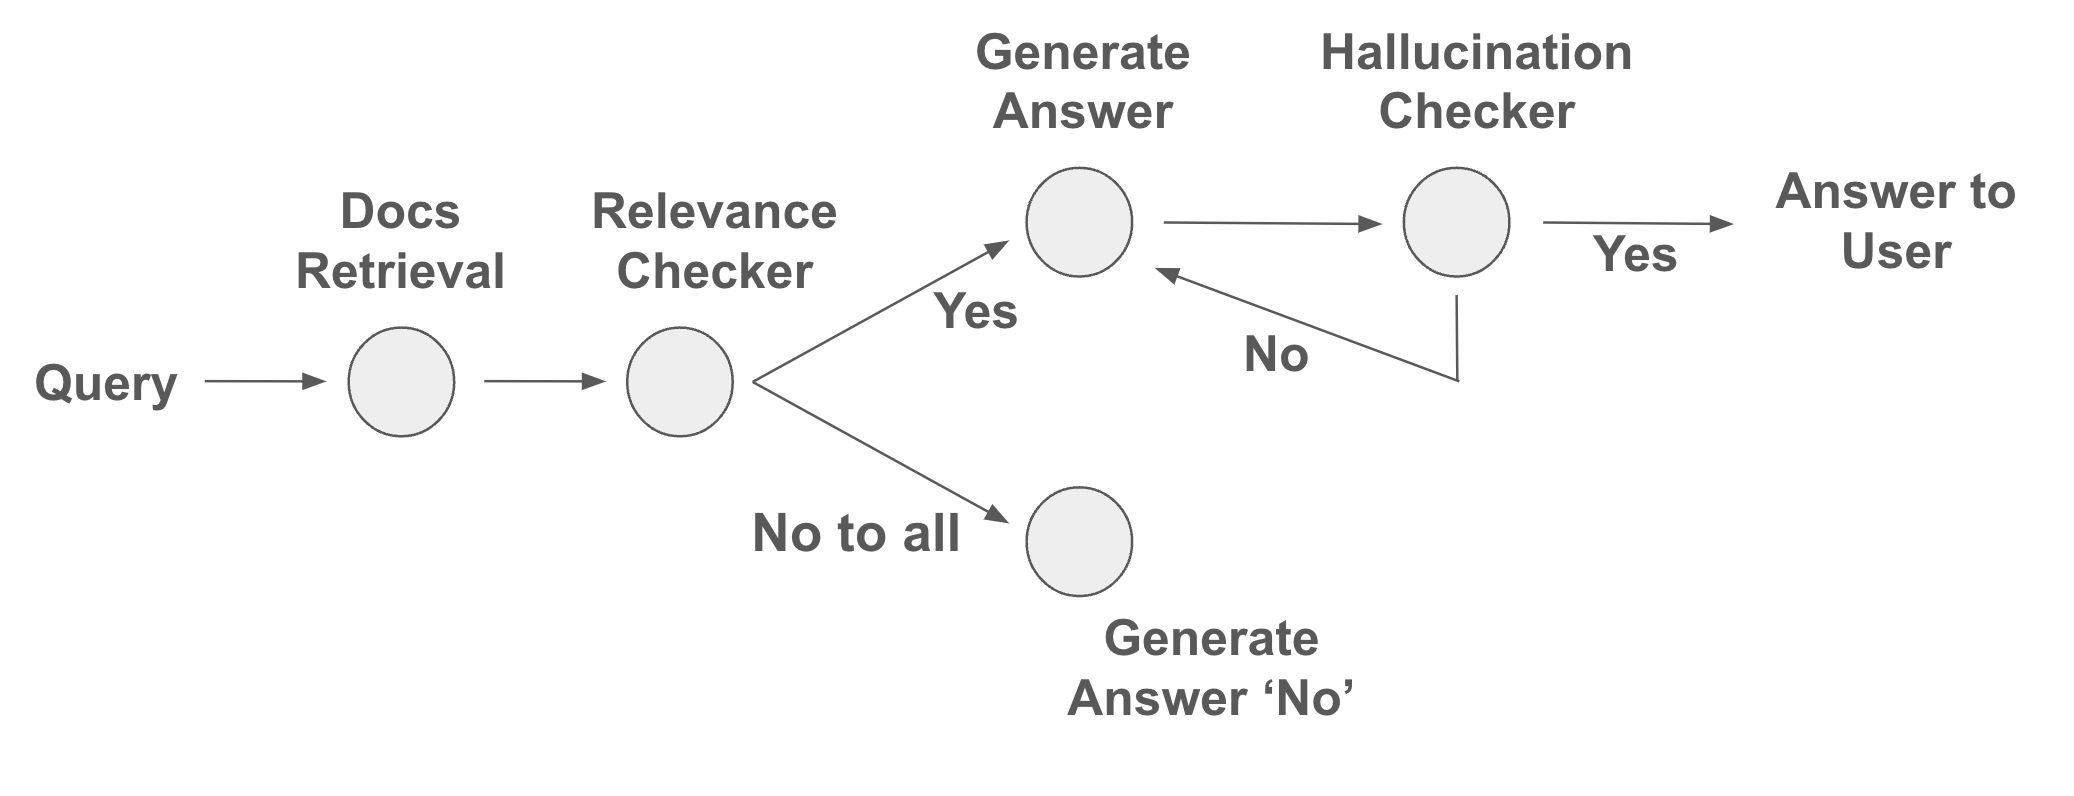

프레임워크
- Langchain
- 비슷한 역할을 하는 Llamaindex 등이 있는데, 학습 단계에서는 이들이 유용하지만, 실제 서빙을 위한 서비스를 개발하다 보면 하나 둘 직접 구현하게 되는 경우가 많음.

모델
- gpt-4o-mini
- Langchain ChatOllama 를 활용하면 Langchain 위에 첫날 실습한 Ollama + Local model 을 활용해서 구현할 수 있음

In [1]:
%%capture --no-stderr
%pip install langchain langchain-openai langchain-openai langchain_chroma langchain-text-splitters langchain_community

In [14]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = ""
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

**기본 RAG tutorial**

Langchain 에 익숙하지 않으신 분은 아래 링크의 튜토리얼 코드를 한 번 읽어보시고 그 다음 과정을 진행해주세요.

https://python.langchain.com/v0.2/docs/tutorials/rag/


In [15]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
print(prompt)

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

output JSON formatting

In [9]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


'Task Decomposition is the process of breaking down complex tasks into smaller, more manageable steps. This can be achieved through techniques like Chain of Thought (CoT), which encourages step-by-step reasoning, or Tree of Thoughts, which explores multiple reasoning paths at each step. It can involve simple prompting, task-specific instructions, or human inputs to effectively guide the task breakdown.'

**1. 3개의 블로그 포스팅 본문을 Load: WebBaseLoader 활용**

https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/

In [66]:
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.vectorstores import Chroma
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]


**2. 불러온 본문을 Split (Chunking) : recursive text splitter 활용**

https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/

In [67]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

doc_splits = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0).split_documents(docs_list)
texts = doc_splits


**3. Chunks 를 임베딩하여 Vector store 저장: openai, chroma 사용**

embedding model 은 "text-embedding-3-small" 사용

embedding: https://python.langchain.com/v0.2/docs/integrations/text_embedding/openai/

vetor store: https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/

In [49]:
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 49.2 MB/s eta 0:00:00


In [68]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_chroma import Chroma
from langchain_community.vectorstores import FAISS


embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(texts, embeddings)
retriever = vectorstore.as_retriever()

docs = retriever.invoke("what did the president say about ketanji brown jackson?")


**4. User query = ‘agent memory’ 를 받아 관련된 chunks를 retrieve**

state_of_the_union.txt 는 여기서 다운로드 받아주세요

https://github.com/hwchase17/chat-your-data/blob/master/state_of_the_union.txt

https://python.langchain.com/v0.2/docs/how_to/vectorstore_retriever/

https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html#langchain_core.vectorstores.VectorStore.as_retriever

In [73]:
from langchain_community.document_loaders import TextLoader
# from langchain_community.vectorstores import FAISS
# from langchain_openai import OpenAIEmbeddings
# from langchain_text_splitters import CharacterTextSplitter


loader = TextLoader("state_of_the_union.txt")

documents = loader.load()
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# texts = text_splitter.split_documents(documents)
# embeddings = OpenAIEmbeddings()
# vectorstore = FAISS.from_documents(texts, embeddings)

# retriever = vectorstore.as_retriever()

# docs = retriever.invoke("what did the president say about ketanji brown jackson?")

In [71]:
# Retrieve more documents with higher diversity
# Useful if your dataset has many similar documents
vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 6, 'lambda_mult': 0.25}
)

# Fetch more documents for the MMR algorithm to consider
# But only return the top 5
vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={'k': 5, 'fetch_k': 50}
)

# Only retrieve documents that have a relevance score
# Above a certain threshold
vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.8}
)

# Only get the single most similar document from the dataset
vectorstore.as_retriever(search_kwargs={'k': 1})

# Use a filter to only retrieve documents from a specific paper
vectorstore.as_retriever(
    search_kwargs={'filter': {'paper_title':'GPT-4 Technical Report'}}
)

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7a8bf72f5a50>, search_kwargs={'filter': {'paper_title': 'GPT-4 Technical Report'}})

**5. User query와 retrieved chunk 에 대해 relevance 가 있는지를 평가하는 시스템 프롬프트 작성: retrieval 퀄리티를 LLM 이 스스로 평가하도록 하고, 관련이 있으면 {‘relevance’: ‘yes’} 관련이 없으면 {‘relevance’: ‘no’} 라고 출력하도록 함. ( JsonOutputParser() 를 활용 )**


RAG 용 프롬프트 작성을 위한 Prompt Hub 활용

https://smith.langchain.com/hub/rlm/rag-prompt

In [72]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")
prompt

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [53]:
example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

output JSON formatting

https://python.langchain.com/v0.2/docs/how_to/output_parser_json/#without-pydantic

In [54]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

joke_query = ""

llm = ChatOpenAI(model="gpt-4o-mini", format= "json", temperature=0)

parser = JsonOutputParser()

prompt = PromptTemplate(
    template="you can evaluate ",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

chain.invoke({"query": joke_query})

{'joke': "Why don't scientists trust atoms? Because they make up everything!"}

```
{'response': "Sure! Here's a joke for you: Why couldn't the bicycle stand up by itself? Because it was two tired!"}
```

6. 5 에서 모든 docs에 대해 ‘no’ 라면 디버깅 (Splitter, Chunk size, overlap, embedding model, vector store, retrieval 평가 시스템 프롬프트 등)

7. 5에서 ‘yes’ 라면 질문과 명확히 관련 없는 docs 나 질문 (예: ‘I like an apple’)에 대해서는 ‘no’ 라고 나오는지 테스트 프롬프트 및 평가 코드 작성. 이 때는 관련 없다는 답변 작성

8. ‘yes’ 이고 7의 평가에서도 문제가 없다면, 4의 retrieved chunk 를 가지고 답변 작성
prompt | llm | parser 코드 작성

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)

9. 생성된 답안에 Hallucination 이 있는지 평가하는 시스템 프롬프트 작성. LLM이 스스로 평가하도록 하고, hallucination 이 있으면 {‘hallucination’: ‘yes’} 없으면 {‘hallucination’: ‘no’} 라고 출력하도록 함

10. 9 에서 ‘yes’ 면 8 로 돌아가서 다시 생성, ‘no’ 면 답변 생성하고 유저에게 답변 생성에 사용된 출처와 함께 출력 (최대 2번까지 다시 생성)

11. https://applied-llms.org/ 링크는 llm 을 이용해 1년간 개발해 본 팀이 배운 것들을 정리한 아티클 입니다.

저자의 생각을 묻는 질문들에 답하기 위해서

1) Chunking & embedding & storing

2) Load

3) Retrieval

4) Generation

으로 구성된 RAG 코드를 작성하고 아래 예시 질문에 대한 답을 해보세요.

예시)
RAG 에 대한 저자의 생각은 무엇인가?
RAG 와 fine tuning 에 대해 저자는 어떻게 비교하고 있나?
저자가 가장 많은 부분을 할당해 설명하는 개념은 무엇인가?

11 실습을 마치지 못했더라도, https://applied-llms.org/ 아티클은 꼭 읽어 보시기를 추천 드립니다.